# Learning to Rank with Python

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Ranking model
import xgboost as xgb
from xgboost import DMatrix

# Evaluating the ranking model
from sklearn.metrics import dcg_score
from sklearn.metrics import ndcg_score

# ML model evaluation, regression
from sklearn.metrics import mean_squared_error

# ML model evaluation, classification
import sklearn 
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

import random
from random import randint

In [3]:
print('np: ',np.__version__)
print('pd: ',pd.__version__)
print('matplotlib: ',matplotlib.__version__)
print('sns: ',sns.__version__)
print('xgb: ', xgb.__version__)
print('sklearn: ',sklearn.__version__)

np:  1.22.3
pd:  1.5.1
matplotlib:  3.6.2
sns:  0.12.2
xgb:  1.7.3
sklearn:  1.0.2


### Data ingest

We use a 50K-row portion of the query-response dataset to speed up the calculation.

In [5]:
#df_train = pd.read_csv('./data/data_train_letor_cleaned_2021JAN14_10K.csv')
#df_test = pd.read_csv('./data/data_test_letor_cleaned_2021JAN14_10K.csv')

df_train = pd.read_csv('./data/data_Xy_0_4_10K.csv')
df_test = pd.read_csv('./data/data_Xy_0_4_10K.csv')

#df_train = df_train.head(10000) 
#df_test = df_test.head(10000)
df_train = df_train.head(50000) 
df_test = df_test.head(50000)

print(df_train.shape, df_train.columns)
df_train.head(2)

(10146, 137) Index(['covered query term number: body', 'covered query term number: anchor',
       'covered query term number: title', 'covered query term number: url',
       'covered query term number: whole document',
       'covered query term ratio: body', 'covered query term ratio: anchor',
       'covered query term ratio: title', 'covered query term ratio: url',
       'covered query term ratio: whole document',
       ...
       'Inlink number', 'Outlink number', 'PageRank', 'SiteRank',
       'QualityScore', 'QualityScore2', 'Query-url click count',
       'url click count', 'url dwell time', 'Label'],
      dtype='object', length=137)


,covered query term number: body,covered query term number: anchor,covered query term number: title,covered query term number: url,covered query term number: whole document,covered query term ratio: body,covered query term ratio: anchor,covered query term ratio: title,covered query term ratio: url,covered query term ratio: whole document,...,Inlink number,Outlink number,PageRank,SiteRank,QualityScore,QualityScore2,Query-url click count,url click count,url dwell time,Label
0,3.0,0.0,1.0,1.0,3.0,1.0,0.0,0.333333,0.333333,1.0,...,1.0,5.0,3375.0,59803.0,6.0,4.0,0.0,0.0,0.000000,0.0
1,2.0,0.0,2.0,0.0,2.0,1.0,0.0,1.000000,0.000000,1.0,...,1.0,4.0,5107.0,36501.0,2.0,4.0,0.0,25.0,38.923333,4.0


### Prepare data for machine learning

In [12]:
df_y_train = df_train['Label']
df_X_train = df_train.drop(columns=['Label', 'group'])
print(df_train.shape, df_X_train.shape, df_y_train.shape)

df_y_test = df_test['Label']
df_X_test = df_test.drop(columns=['Label', 'group'])
df_g_test = df_test['group']
print(df_test.shape, df_X_test.shape, df_y_test.shape)

(50000, 138) (50000, 136) (50000,)
(50000, 138) (50000, 136) (50000,)


In [13]:
X_train = df_X_train.values
y_train = df_y_train.values

X_test = df_X_test.values
y_test = df_y_test.values
g_test = df_g_test.values

training_data = DMatrix(X_train, y_train)
testing_data = DMatrix(X_test, y_test)

#### Extract and set group sizes

In [14]:
def get_group_sizes(df):
    '''
    '''
    grps_uniq = df['group'].unique()
    grp_sizes = []
    for grp in grps_uniq:
        df_grp = df[df['group'] == grp]
        grp_sizes.append(df_grp.shape[0])
        
    return grp_sizes

In [15]:
train_group_sizes = get_group_sizes(df_train)
test_group_sizes = get_group_sizes(df_test)

In [16]:
#testing_data.set_group(g_test) # is this correct?

training_data.set_group(train_group_sizes)
testing_data.set_group(test_group_sizes)

### Train ranking model

#### Ranking Algorithms

In [17]:
param_ranknet = {'max_depth':6, 'eta':0.3, 'objective':'rank:map'}
param_lambdarank = {'max_depth':6, 'eta':0.3, 'objective':'rank:pairwise'} # 'num_round':10'silent':0
param_lambdamart = {'max_depth':6, 'eta':0.3, 'objective':'rank:ndcg'}

model_ranknet = xgb.train(param_ranknet, training_data);
model_lamdarank = xgb.train(param_lambdarank, training_data);
model_lambdamart = xgb.train(param_lambdamart, training_data);

preds_train_ranknet = model_ranknet.predict(training_data)
preds_test_ranknet = model_ranknet.predict(testing_data)
df_train['preds_ranknet'] = preds_train_ranknet
df_test['preds_ranknet'] = preds_test_ranknet

preds_train_lambdarank = model_lamdarank.predict(training_data)
preds_test_lambdarank = model_lamdarank.predict(testing_data)
df_train['preds_lambdarank'] = preds_train_lambdarank
df_test['preds_lambdarank'] = preds_test_lambdarank

preds_train_lambdamart = model_lambdamart.predict(training_data)
preds_test_lambdamart = model_lambdamart.predict(testing_data)
df_train['preds_lambdamart'] = preds_train_lambdamart
df_test['preds_lambdamart'] = preds_test_lambdamart

#### Classification Model 

In [21]:
xg_clf = xgb.XGBClassifier(max_depth=6, objective='multi:softmax')
xg_clf.fit(X_train, y_train)
y_pred_train = xg_clf.predict(X_train)
y_pred_test = xg_clf.predict(X_test)
df_train['preds_classifier'] = y_pred_train
df_test['preds_classifier'] = y_pred_test

#### Random Model (see readme)

In [60]:
df_train['preds_random'] = [randint(0, 4) for p in range(0, df_train.shape[0])]
df_test['preds_random'] = [randint(0, 4) for p in range(0, df_test.shape[0])]

In [61]:
df_test['preds_random']

0        0
1        2
2        2
3        1
4        4
        ..
49995    2
49996    3
49997    1
49998    2
49999    1
Name: preds_random, Length: 50000, dtype: int64

### Evaluate the ranking

In [22]:
def score_ranking(df_all, preds_col):
    '''
    '''
    df_all = df_all.copy()
    ndcg_score_1 = []
    ndcg_score_vec = []

    for group in df_all['group'].unique():
        df_grp = []
        ndcg_score_1 = []
        df_grp = df_all[df_all['group'] == group]
        ndcg_score_1 = ndcg_score([df_grp['Label'].to_list()], 
                                  [df_grp[preds_col].to_list()])
        ndcg_score_vec.append(ndcg_score_1)
    
    return ndcg_score_vec

In [62]:
ndcg_scores_test_ranknet = score_ranking(df_test, 'preds_ranknet')
ndcg_scores_train_ranknet = score_ranking(df_train, 'preds_ranknet')

ndcg_scores_test_lambdarank = score_ranking(df_test, 'preds_lambdarank')
ndcg_scores_train_lambdarank = score_ranking(df_train, 'preds_lambdarank')

ndcg_scores_test_lambdamart = score_ranking(df_test, 'preds_lambdamart')
ndcg_scores_train_lambdamart = score_ranking(df_train, 'preds_lambdamart')

ndcg_scores_test_classifier = score_ranking(df_test, 'preds_classifier')
ndcg_scores_train_classifier = score_ranking(df_train, 'preds_classifier')

ndcg_scores_test_random = score_ranking(df_test, 'preds_random')
ndcg_scores_train_random = score_ranking(df_train, 'preds_random')

In [63]:
print(np.mean(ndcg_scores_train_ranknet), np.std(ndcg_scores_train_ranknet), np.median(ndcg_scores_train_ranknet))
print(np.mean(ndcg_scores_test_ranknet), np.std(ndcg_scores_test_ranknet),np.median(ndcg_scores_test_ranknet))
print(" ")
print(np.mean(ndcg_scores_train_lambdarank), np.std(ndcg_scores_train_lambdarank),np.median(ndcg_scores_train_lambdarank))
print(np.mean(ndcg_scores_test_lambdarank), np.std(ndcg_scores_test_lambdarank) ,np.median(ndcg_scores_test_lambdarank))
print(" ")
print(np.mean(ndcg_scores_train_lambdamart), np.std(ndcg_scores_train_lambdamart),np.median(ndcg_scores_train_lambdamart))
print(np.mean(ndcg_scores_test_lambdamart), np.std(ndcg_scores_test_lambdamart), np.median(ndcg_scores_test_lambdamart))
print(" ")
print(np.mean(ndcg_scores_train_classifier), np.std(ndcg_scores_train_classifier),np.median(ndcg_scores_train_classifier))
print(np.mean(ndcg_scores_test_classifier),np.std(ndcg_scores_test_classifier) ,np.median(ndcg_scores_test_classifier))
print(" ")
print(np.mean(ndcg_scores_train_random), np.std(ndcg_scores_train_random),np.median(ndcg_scores_train_random))
print(np.mean(ndcg_scores_test_random),np.std(ndcg_scores_test_random) ,np.median(ndcg_scores_test_random))

0.7592793187003712 0.132276708379272 0.7802638014482798
0.7228999795006154 0.1491944614186254 0.7465016218603787
 
0.7879554752908572 0.1367271629446792 0.8221698928839302
0.7474663176525514 0.1545824683031473 0.7858863885032823
 
0.774632000940681 0.1291809526636206 0.7987970539970299
0.7302634582652903 0.1560281638869699 0.7673134158553447
 
0.8484908876188219 0.17226428315062303 0.9133868249415895
0.7012500726145249 0.1606881174475421 0.7444902772707191
 
0.6139344434438637 0.1480423232147298 0.6426076231433504
0.6239925132620211 0.15049330760875568 0.6522173801015718


#### Check for class collapse in the classifer

In [25]:
df_train['Label'].value_counts()

0.0    29384
1.0    13669
2.0     6043
3.0      658
4.0      246
Name: Label, dtype: int64

In [26]:
df_train['preds_classifier'].value_counts()

0.0    35355
1.0    10987
2.0     2938
3.0      475
4.0      245
Name: preds_classifier, dtype: int64

In [27]:
df_test['Label'].value_counts()

0.0    28225
1.0    14094
2.0     6623
3.0      823
4.0      235
Name: Label, dtype: int64

In [28]:
df_test['preds_classifier'].value_counts()

0.0    36669
1.0    11005
2.0     2235
4.0       47
3.0       44
Name: preds_classifier, dtype: int64

Note that the classifier is not simply predicting the majority class . . . a crude but useful check.

### Visualize Results

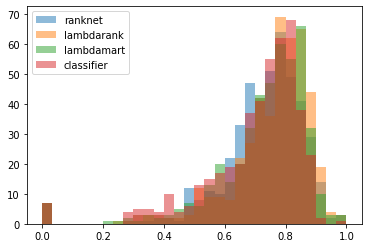

In [30]:
plt.figure()
plt.hist(ndcg_scores_test_ranknet, bins=30, label='ranknet', alpha=0.5);
plt.hist(ndcg_scores_test_lambdarank, bins=30, label='lambdarank', alpha=0.5);
plt.hist(ndcg_scores_test_lambdamart, bins=30, label='lambdamart', alpha=0.5);
plt.hist(ndcg_scores_test_classifier, bins=30, label='classifier', alpha=0.5);
plt.legend()

In [64]:
#df_scores = pd.DataFrame(columns=['algorithm','score'])

#df_tmp = []
df_scores_ranknet = pd.DataFrame({'algorithm':'ranknet',
                       'score': ndcg_scores_test_ranknet
                      })
df_scores_lambdarank = pd.DataFrame({'algorithm':'lambdarank',
                       'score': ndcg_scores_test_lambdarank
                      })
df_scores_lambdamart = pd.DataFrame({'algorithm':'lambdamart',
                       'score': ndcg_scores_test_lambdamart
                      })
df_scores_classifier = pd.DataFrame({'algorithm':'classifier',
                       'score': ndcg_scores_test_classifier
                      })
df_scores_random = pd.DataFrame({'algorithm':'random',
                       'score': ndcg_scores_test_random
                      })
df_scores = pd.concat([df_scores_ranknet, df_scores_lambdarank, df_scores_lambdamart, df_scores_classifier, df_scores_random])

df_scores

,algorithm,score
0,ranknet,0.875252
1,ranknet,0.834931
2,ranknet,0.566327
3,ranknet,0.627582
4,ranknet,0.768009
...,...,...
451,random,0.718385
452,random,0.654419
453,random,0.556000
454,random,0.753067


<Figure size 432x288 with 0 Axes>

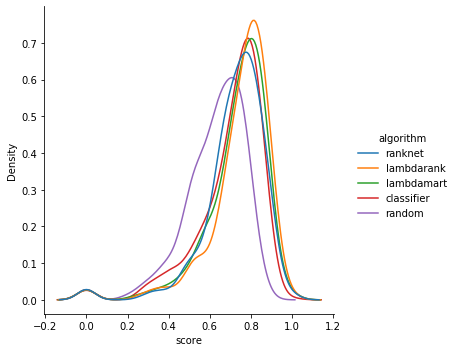

In [65]:
plt.figure()
sns.displot(df_scores, x='score', hue='algorithm', kind='kde')

In [67]:
print('Algorithm: Random')
df_scores_random['score'].describe()

Algorithm: Random


count    456.000000
mean       0.623993
std        0.150659
min        0.000000
25%        0.541745
50%        0.652217
75%        0.731037
max        0.881100
Name: score, dtype: float64

In [33]:
print('Algorithm: Classifier')
df_scores_classifier['score'].describe()

Algorithm: Classifier


count    456.000000
mean       0.701250
std        0.160865
min        0.000000
25%        0.642645
50%        0.744490
75%        0.808182
max        1.000000
Name: score, dtype: float64

In [34]:
print('Algorithm: RankNet')
df_scores_ranknet['score'].describe()

Algorithm: RankNet


count    456.000000
mean       0.722900
std        0.149358
min        0.000000
25%        0.666739
50%        0.746502
75%        0.817264
max        1.000000
Name: score, dtype: float64

In [35]:
print('Algorithm: LambdaRank')
df_scores_lambdarank['score'].describe()

Algorithm: LambdaRank


count    456.000000
mean       0.747466
std        0.154752
min        0.000000
25%        0.703637
50%        0.785886
75%        0.842141
max        1.000000
Name: score, dtype: float64

In [36]:
print('Algorithm: LambdaMart')
df_scores_lambdamart['score'].describe()

Algorithm: LambdaMart


count    456.000000
mean       0.730263
std        0.156200
min        0.000000
25%        0.679672
50%        0.767313
75%        0.832004
max        1.000000
Name: score, dtype: float64

In [68]:
df_scores = pd.DataFrame({'Algorithm':['Classifier', 'Random','RankNet','LambdaRank','LambdaMart'],
                          'Mean NCDG Score': [0.701250, 0.623993,0.722900, 0.747466, 0.730263]
    
})

(0.5, 0.8)

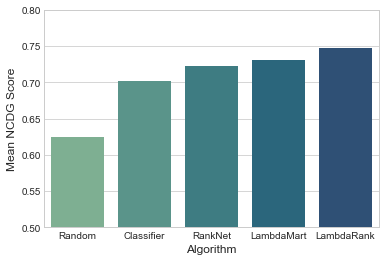

In [84]:
plt.figure()
plt.style.use('seaborn-whitegrid')
df_scores = df_scores.sort_values(by=['Mean NCDG Score'])
sns.barplot(x=df_scores['Algorithm'], y=df_scores['Mean NCDG Score'], palette='crest')
plt.ylim(0.5, 0.80)

### Discussion

We see that the ranking algorithms achieve a mean NCDG score higher than both the random model and the classification model, but it is closer than you might expect. LambdaRank also does slightly better than LambdMart, which also warrants further investigation. The next steps here will be to explore hyperparameter settings and expand the model training to a larger fraction of the dataset. 